In [2]:
import pandas as pd

def create_df_from_sheet(sheet: str) -> pd.DataFrame:
    df = pd.read_excel("./all data(from manon).xlsx", sheet_name=sheet)
    df.columns = df.iloc[1]
    df = df.iloc[2:]
    if len(df.columns) > 4:
        df.drop(columns=df.columns[-2:], axis=1, inplace=True)
    df.columns = ["timestamp", "no_units", "RangeCAL_uS", "SkinResistanceCAL_kOhms"]
    return df


def plot_df(df: pd.DataFrame):
    df.iloc[:, [0, 1]].plot()
    df.iloc[:, [0, 2]].plot()
    df.iloc[:, [0, 3]].plot()
    # print("hi mom")

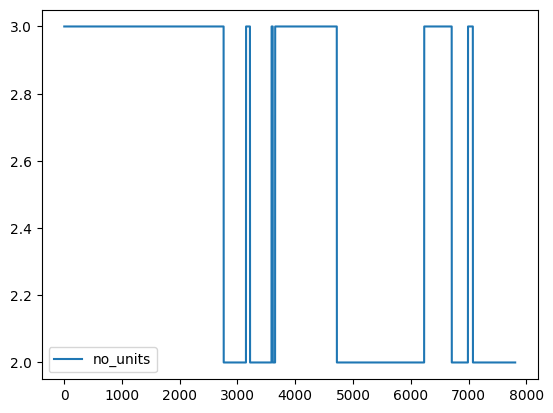

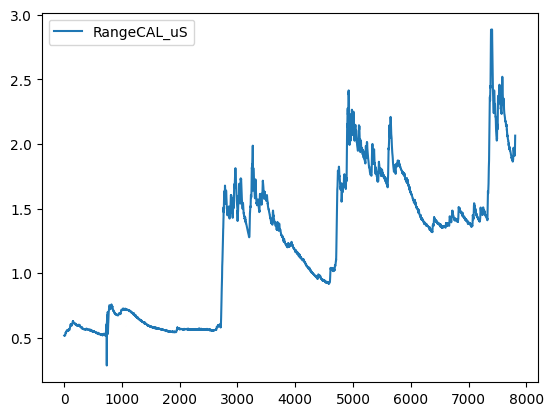

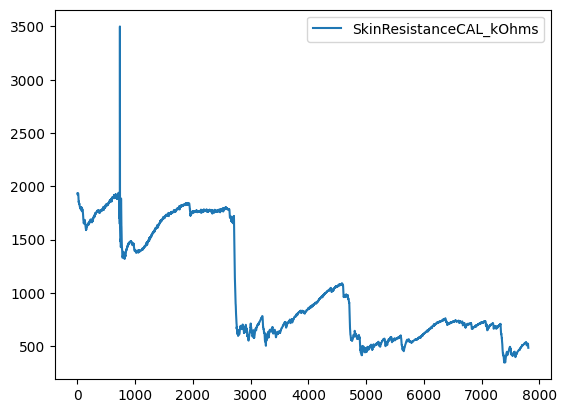

In [3]:
test612_1 = create_df_from_sheet("612_1")
plot_df(test612_1)

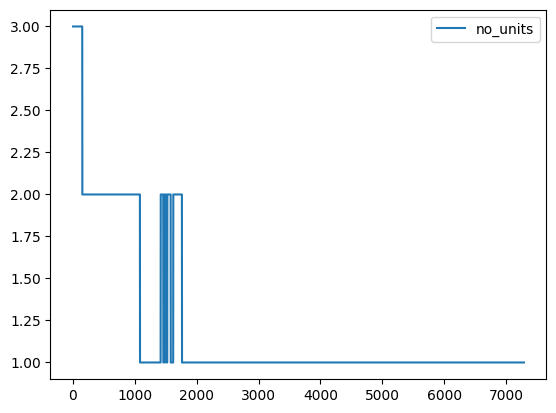

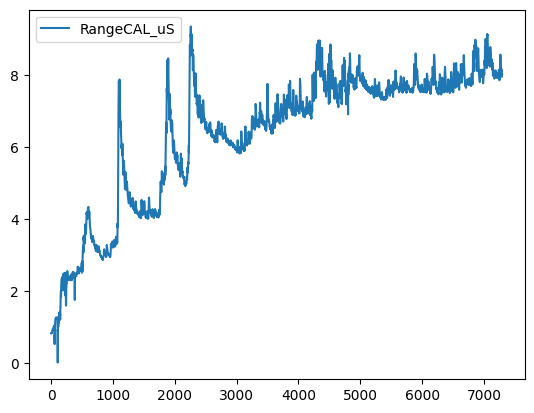

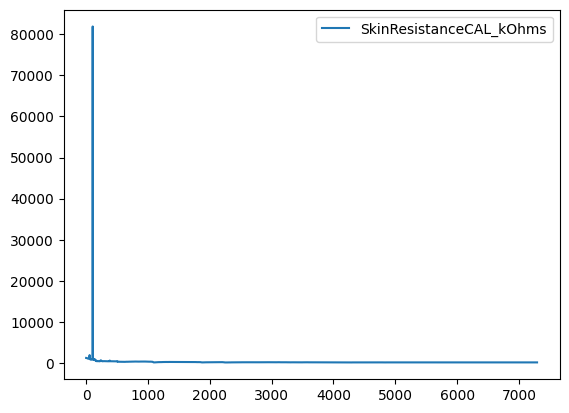

In [4]:
test612_2 = create_df_from_sheet("612_2")
plot_df(test612_2)

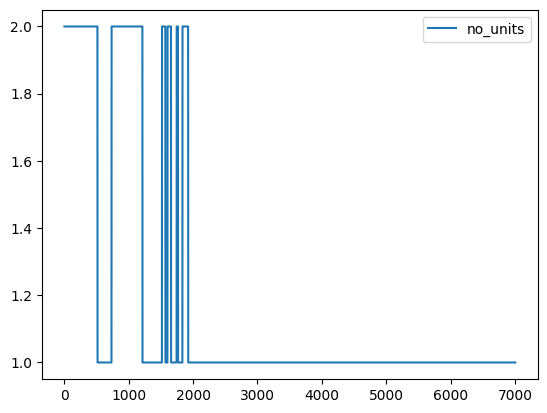

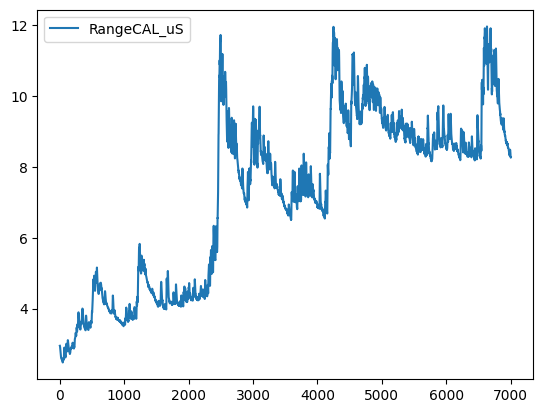

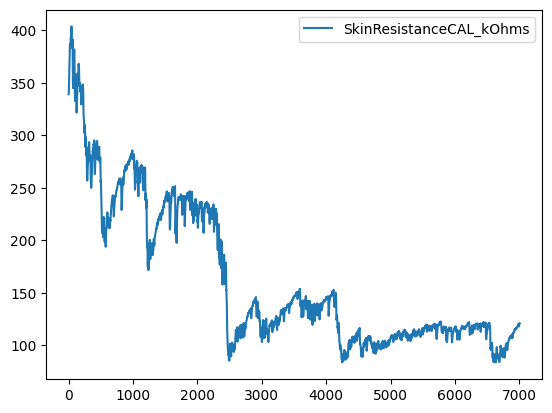

In [5]:
test612_3 = create_df_from_sheet("612_3")
plot_df(test612_3)

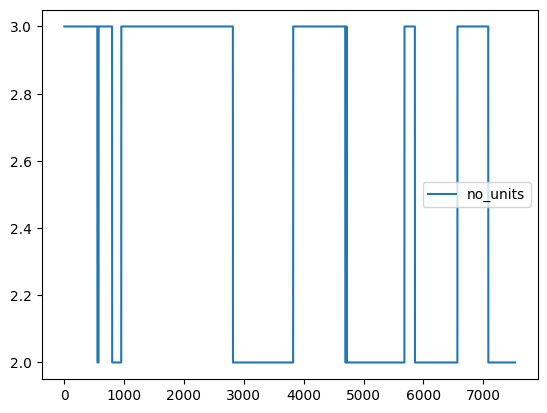

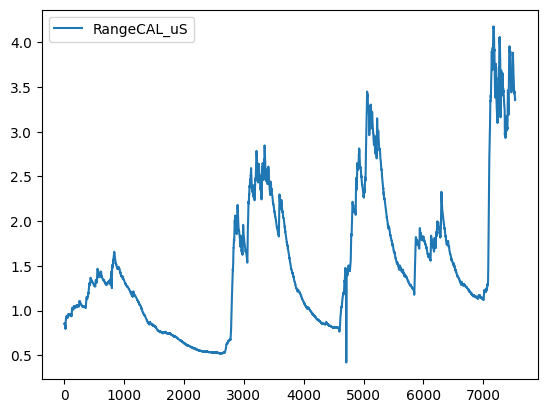

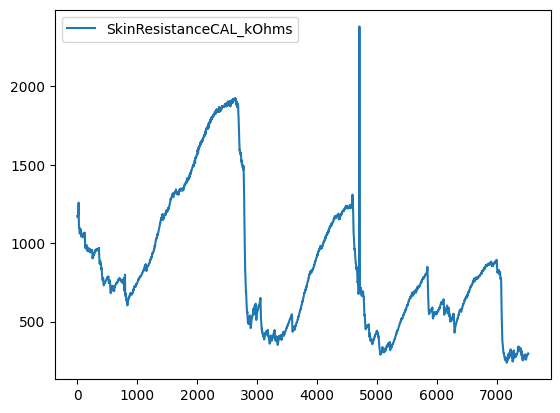

In [6]:
test612_4 = create_df_from_sheet("612_4")
plot_df(test612_4)

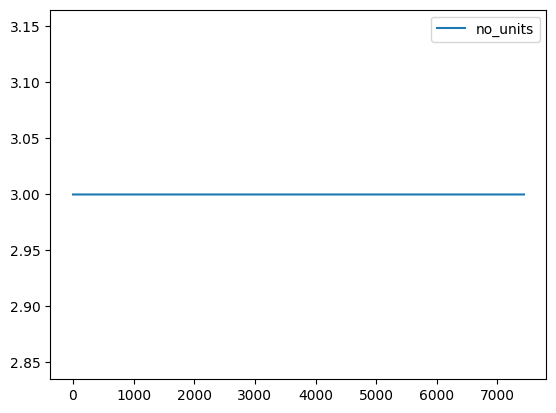

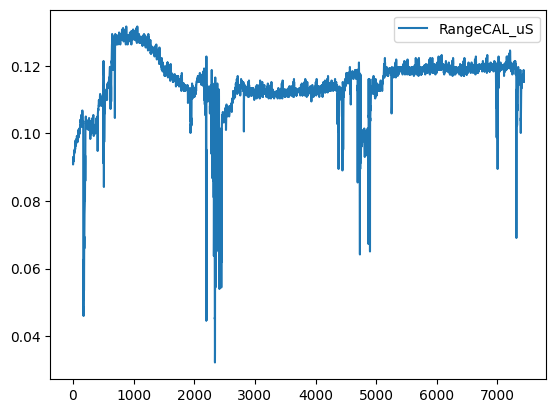

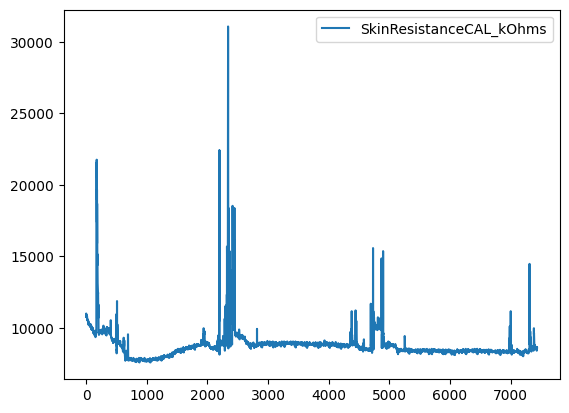

In [7]:
test612_5 = create_df_from_sheet("612_5")
plot_df(test612_5)

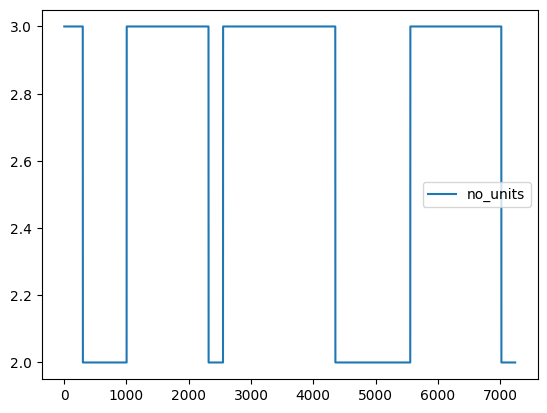

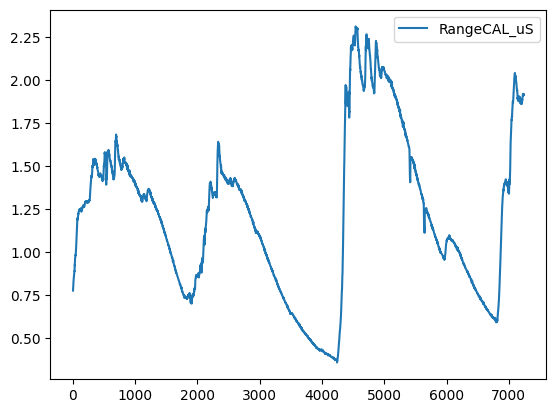

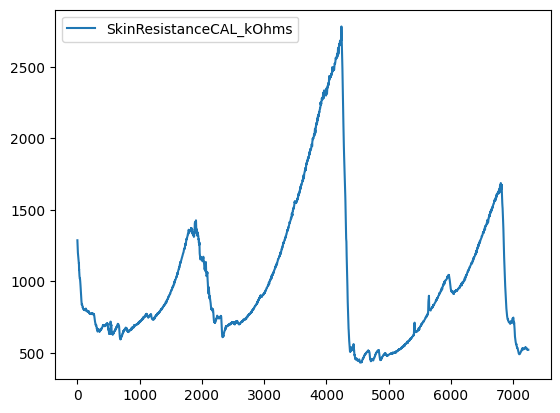

In [8]:
test612_6 = create_df_from_sheet("612_6")
plot_df(test612_6)

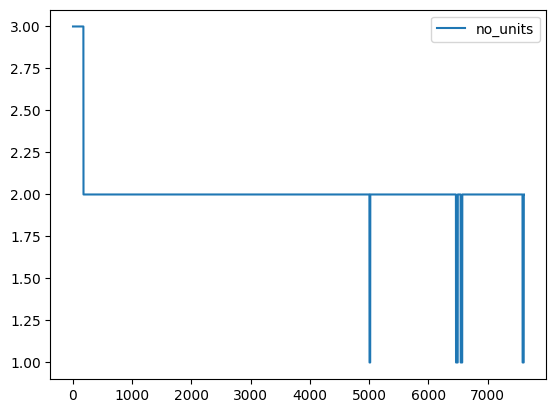

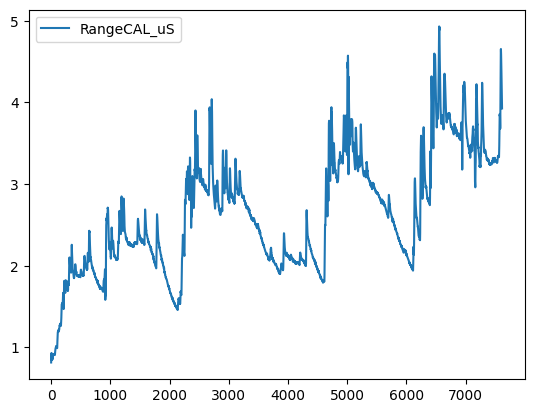

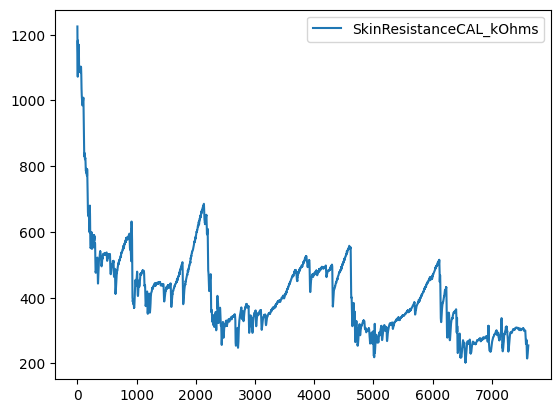

In [9]:
test612_7 = create_df_from_sheet("612_7")
plot_df(test612_7)

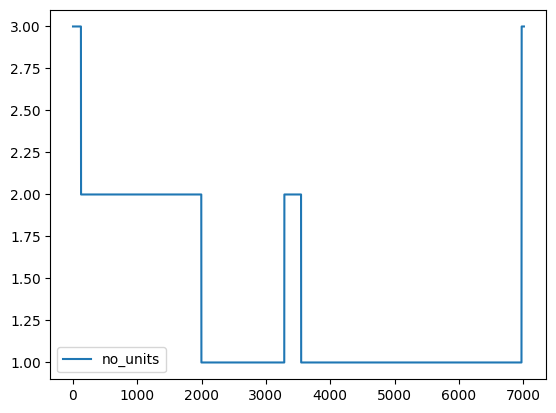

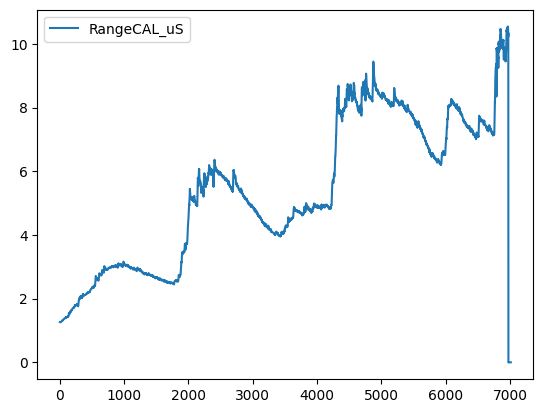

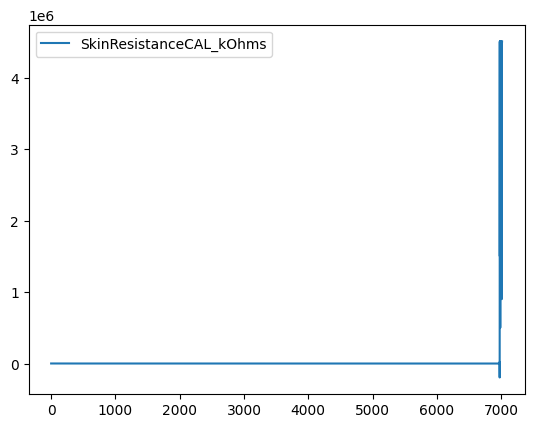

In [10]:
test712_1 = create_df_from_sheet("712_1")
plot_df(test712_1)

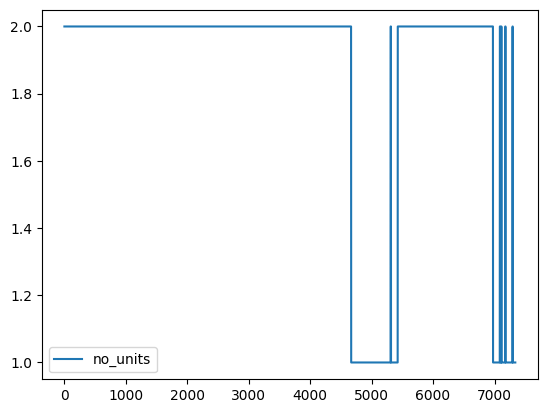

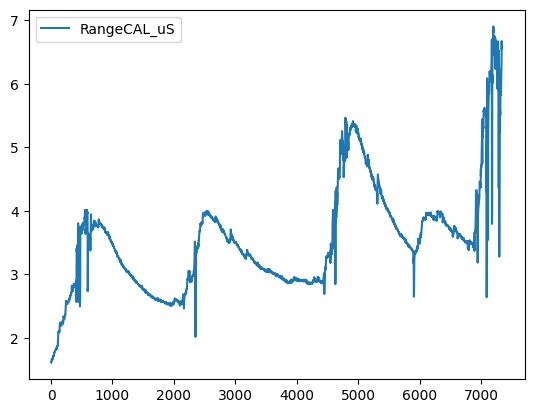

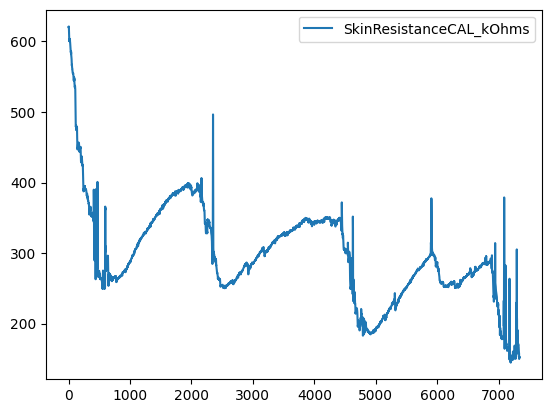

In [11]:
test712_2 = create_df_from_sheet("712_2")
plot_df(test712_2)

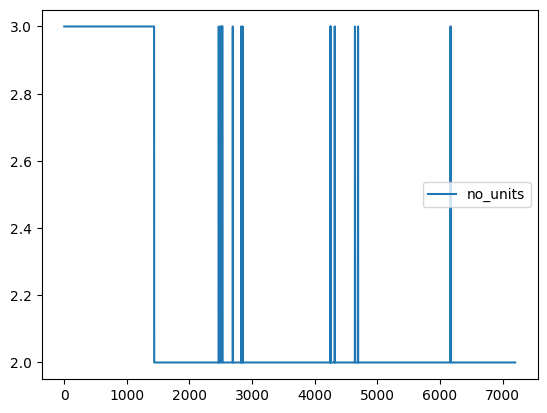

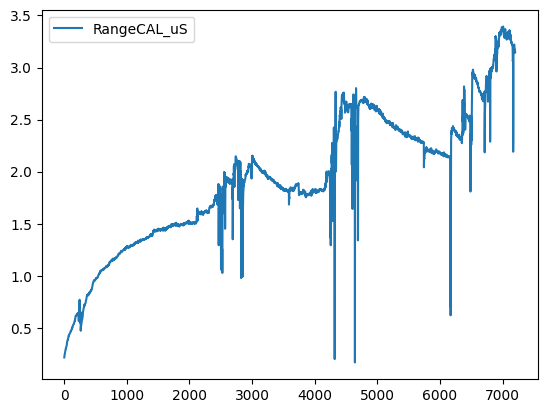

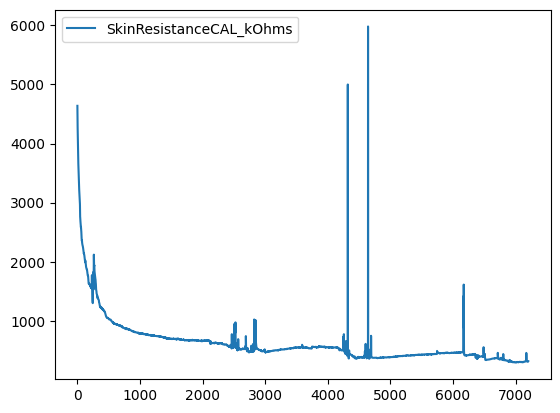

In [12]:
test712_3 = create_df_from_sheet("712_3")
plot_df(test712_3)

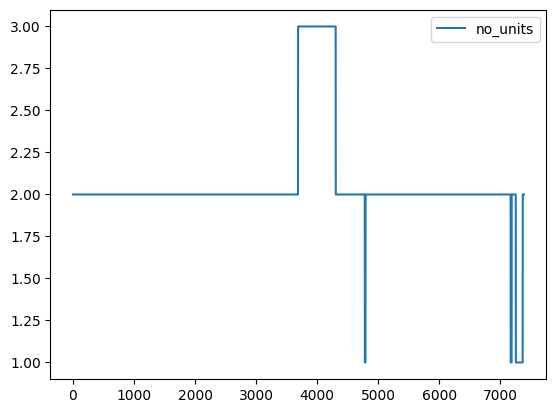

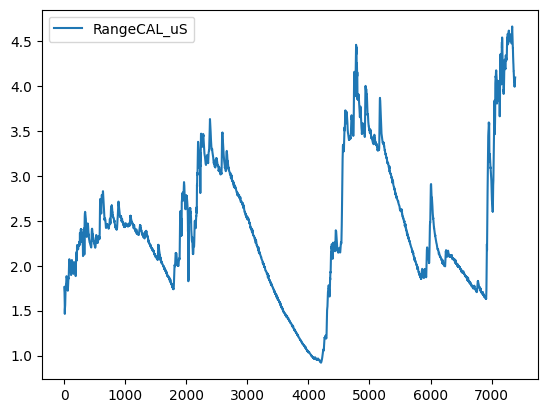

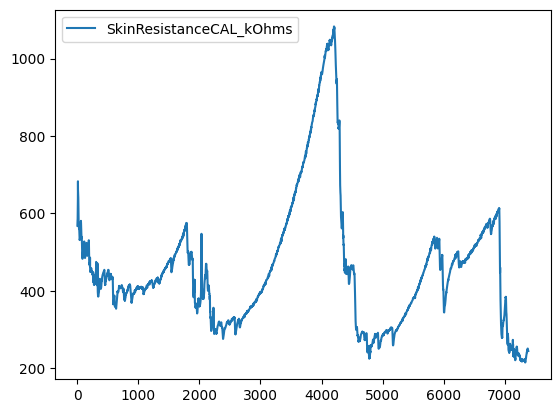

In [13]:
test712_4 = create_df_from_sheet("712_4")
plot_df(test712_4)

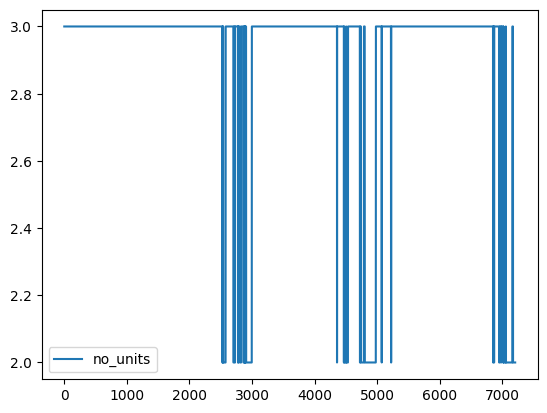

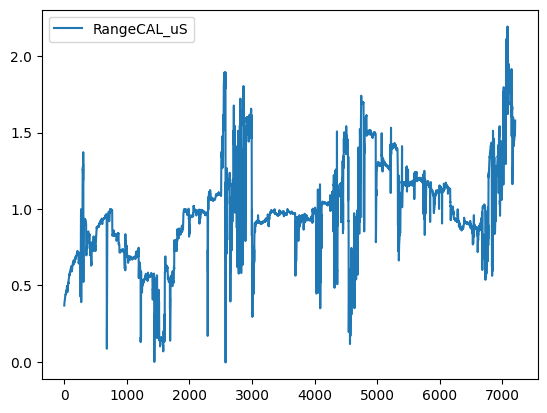

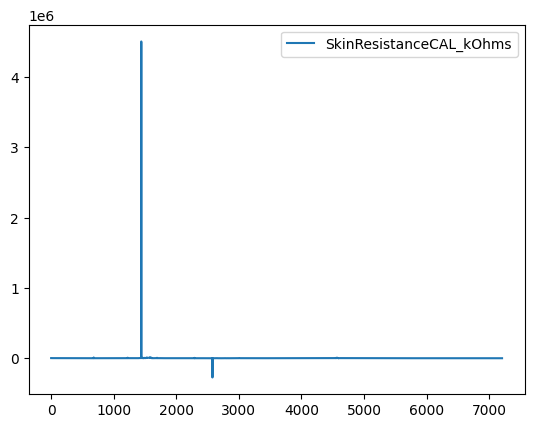

In [14]:
test712_5 = create_df_from_sheet("712_5")
plot_df(test712_5)

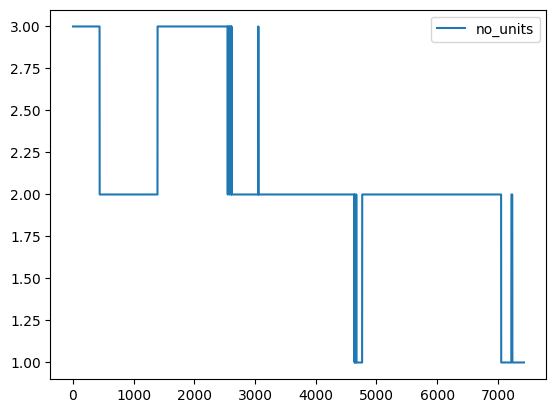

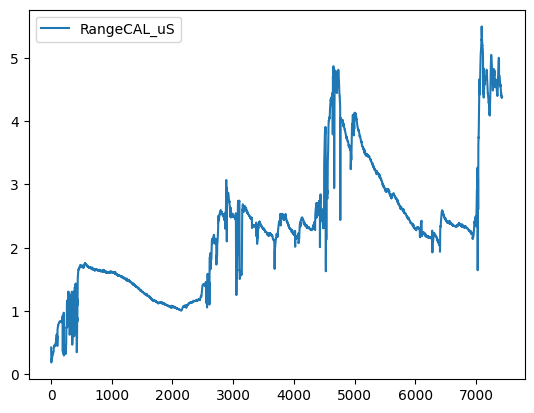

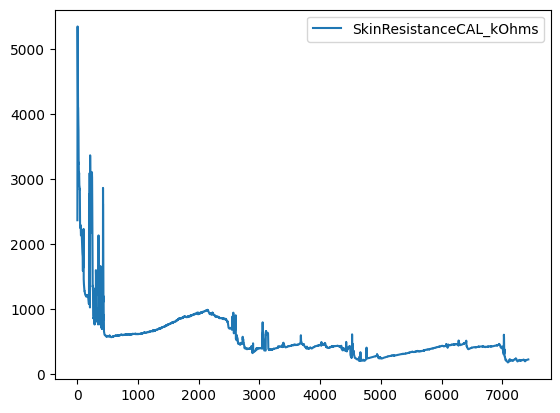

In [15]:
test712_6 = create_df_from_sheet("712_6")
plot_df(test712_6)

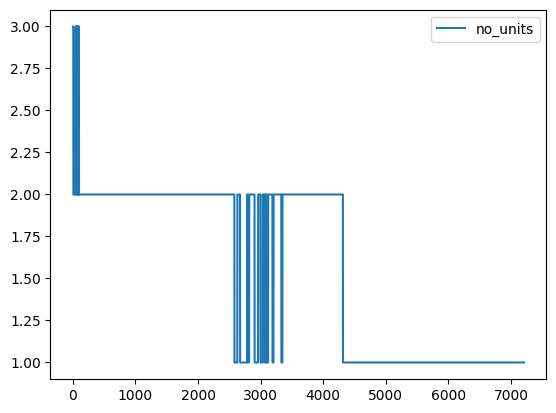

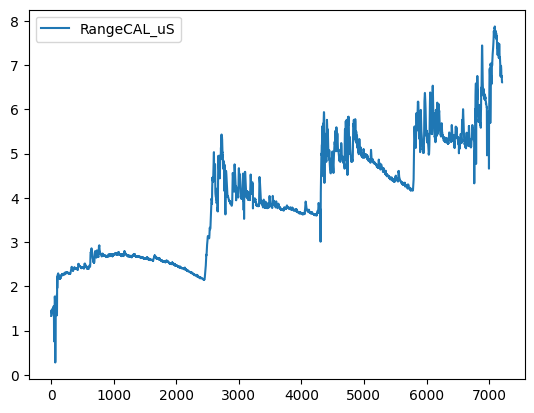

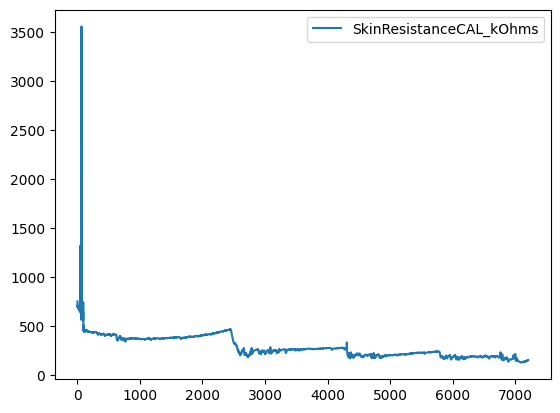

In [16]:
test712_7 = create_df_from_sheet("712_7")
plot_df(test712_7)

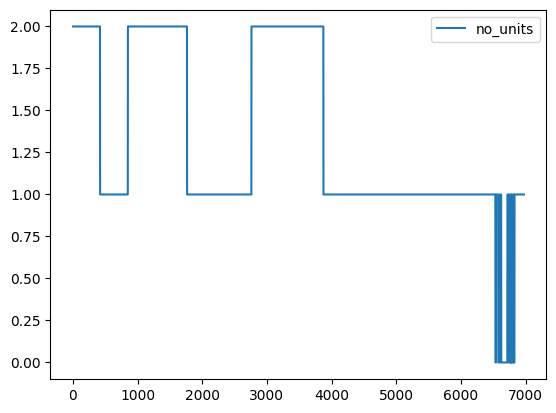

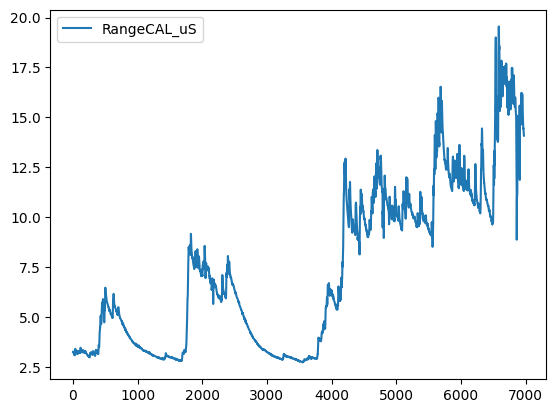

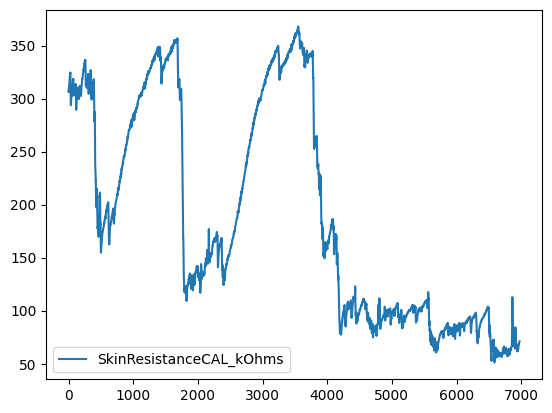

In [17]:
test712_8 = create_df_from_sheet("712_8")
plot_df(test712_8)

In [81]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

dfTemp =  test712_4
dfTemp['RangeCAL_uS'] = scaler.fit_transform(dfTemp[['RangeCAL_uS']])

df1_1 = dfTemp.iloc[:, [0, 1]]
df1_2 = dfTemp.iloc[:, [0, 2]]
df1_3 = dfTemp.iloc[:, [0, 3]]
df1_2

,timestamp,RangeCAL_uS
2,2021/12/07 15:01:22.754,0.223815
3,2021/12/07 15:01:23.004,0.215980
4,2021/12/07 15:01:23.254,0.214021
5,2021/12/07 15:01:23.504,0.211671
6,2021/12/07 15:01:23.754,0.210888
...,...,...
7382,2021/12/07 15:32:08.450,0.844316
7383,2021/12/07 15:32:08.700,0.840007
7384,2021/12/07 15:32:08.950,0.845099
7385,2021/12/07 15:32:09.200,0.847450


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7385 entries, 2 to 7386
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   timestamp    7385 non-null   object 
 1   RangeCAL_uS  7385 non-null   float64
dtypes: float64(1), object(1)
memory usage: 115.5+ KB


/tmp/ipykernel_1863/2562605848.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1_2['RollingMean'] = df1_2['RangeCAL_uS'].rolling(40).mean() # rolling average of 10 seconds (4 units = 1 second)


<AxesSubplot: >

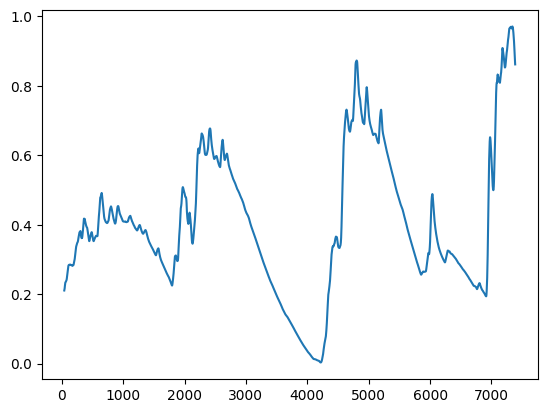

In [82]:

df1_2.info()
df1_2['RollingMean'] = df1_2['RangeCAL_uS'].rolling(40).mean() # rolling average of 10 seconds (4 units = 1 second)

df1_2['RollingMedian'] = df1_2['RangeCAL_uS'].rolling(40).median() # rolling median of 10 seconds
df1_2['deltaMean'] = df1_2.RollingMean.diff(periods =1)
df1_2['deltaMedian'] = df1_2.RollingMedian.diff(periods =1)
df1_2['RollingMean'].plot()

In [83]:
anomaly_detection_df = df1_2[['timestamp', 'deltaMean', 'RollingMean']].copy().dropna()
anomaly_detection_df = anomaly_detection_df.reset_index()
# anomaly_detection_df['time_index'] = anomaly_detection_df.index
anomaly_detection_df

,index,timestamp,deltaMean,RollingMean
0,42,2021/12/07 15:01:32.754,0.000783,0.211475
1,43,2021/12/07 15:01:33.004,0.000979,0.212454
2,44,2021/12/07 15:01:33.254,0.000999,0.213453
3,45,2021/12/07 15:01:33.504,0.001018,0.214472
4,46,2021/12/07 15:01:33.754,0.000989,0.215461
...,...,...,...,...
7340,7382,2021/12/07 15:32:08.450,-0.003073,0.872213
7341,7383,2021/12/07 15:32:08.700,-0.002976,0.869236
7342,7384,2021/12/07 15:32:08.950,-0.002644,0.866592
7343,7385,2021/12/07 15:32:09.200,-0.002381,0.864212


/home/student/.local/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


      index                timestamp  deltaMean  RollingMean    scores  \
1856   1898  2021/12/07 15:09:16.991   0.003388     0.311641 -0.004381   
1858   1900  2021/12/07 15:09:17.491   0.003800     0.319054 -0.006981   
1859   1901  2021/12/07 15:09:17.741   0.003917     0.322971 -0.008227   
1861   1903  2021/12/07 15:09:18.241   0.004074     0.330953 -0.030169   
1864   1906  2021/12/07 15:09:18.990   0.004025     0.342979 -0.008889   
...     ...                      ...        ...          ...       ...   
7337   7379  2021/12/07 15:32:07.700  -0.004187     0.882687 -0.118038   
7338   7380  2021/12/07 15:32:07.950  -0.003869     0.878818 -0.067815   
7339   7381  2021/12/07 15:32:08.200  -0.003532     0.875286 -0.039024   
7340   7382  2021/12/07 15:32:08.450  -0.003073     0.872213 -0.024855   
7341   7383  2021/12/07 15:32:08.700  -0.002976     0.869236 -0.028225   

      anomaly  
1856       -1  
1858       -1  
1859       -1  
1861       -1  
1864       -1  
...       ...  

<AxesSubplot: >

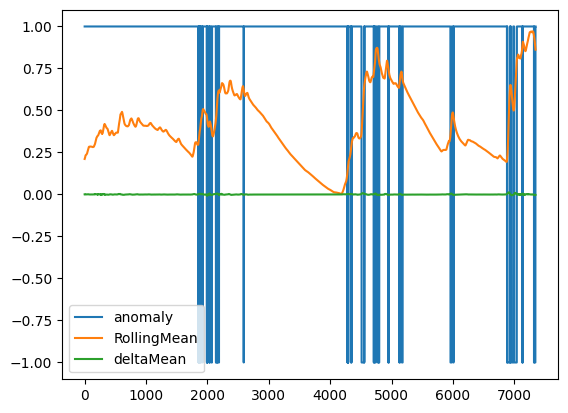

In [84]:
from sklearn.ensemble import IsolationForest

IF = IsolationForest(random_state=0, contamination=0.05, n_estimators=200, max_samples=0.7)
model_data = anomaly_detection_df[['deltaMean']]
IF.fit(model_data)

anomaly_detection_df['scores']=IF.decision_function(model_data)
anomaly_detection_df['anomaly']=IF.predict(model_data)

anomaly=anomaly_detection_df.loc[anomaly_detection_df['anomaly']==-1]
anomaly_index=list(anomaly.index)

print(anomaly)
print(anomaly_index)

anomaly_detection_df[['anomaly', 'RollingMean','deltaMean']].plot()